In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
bs = 4

In [5]:
# path = datapath4file('..\..\..\datasets\dice'); path
path = datapath4file('../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice'); path

PosixPath('/home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice')

In [6]:
Config().data_archive_path()

PosixPath('/home/groot/.fastai/data')

In [7]:
path.ls()

[PosixPath('/home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice/readme.md'),
 PosixPath('/home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice/train'),
 PosixPath('/home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice/export_backup.pkl'),
 PosixPath('/home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice/export.pkl'),
 PosixPath('/home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice/valid'),
 PosixPath('/home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice/resnet34'),
 PosixPath('/home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice/models')]

In [8]:
path_train = path/'train'
path_valid = path/'valid'

In [9]:
fnames = get_image_files(path_train/'d6')
fnames[:10]

[PosixPath('/home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice/train/d6/d6_off-angle_281.jpg'),
 PosixPath('/home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice/train/d6/d6_top_0145.jpg'),
 PosixPath('/home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice/train/d6/d6_45angle_0358.jpg'),
 PosixPath('/home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice/train/d6/d6_color231.jpg'),
 PosixPath('/home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice/train/d6/d6_wood0559.jpg'),
 PosixPath('/home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice/train/d6/d6_top_0033.jpg'),
 PosixPath('/home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice/train/d6/d6_top_0485.jpg'),
 PosixPath('/home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice/train/d6/d6_off-angle_069.jpg'),
 PosixPath('/home/

In [38]:
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.



In [10]:
# from_folder only works if labels are the folder names the files are in
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=256)

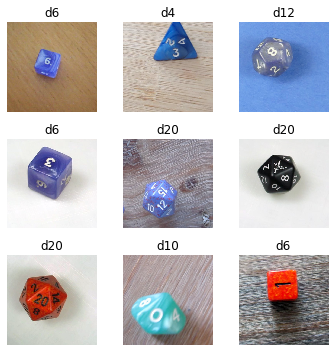

In [34]:
data.show_batch(rows=3, figsize=(5,5))

In [11]:
torch.cuda.empty_cache()

In [36]:
bs = 4

## Resnet 18

In [37]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.037436,0.070793,0.986204,01:36
1,0.020315,0.067940,0.989534,01:36
2,0.019956,0.092038,0.986679,01:37
3,0.016801,0.082083,0.988107,01:35


In [38]:
learn.save('res-18')

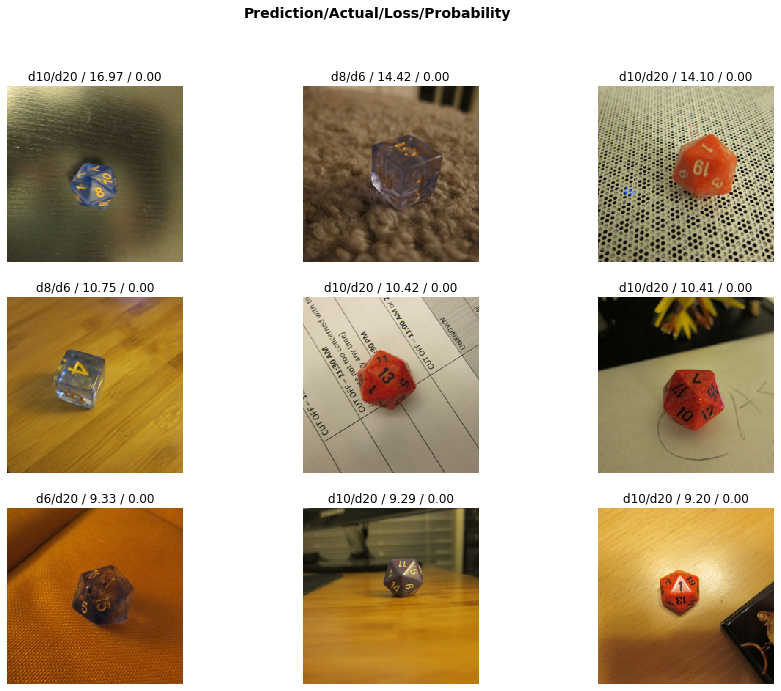

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

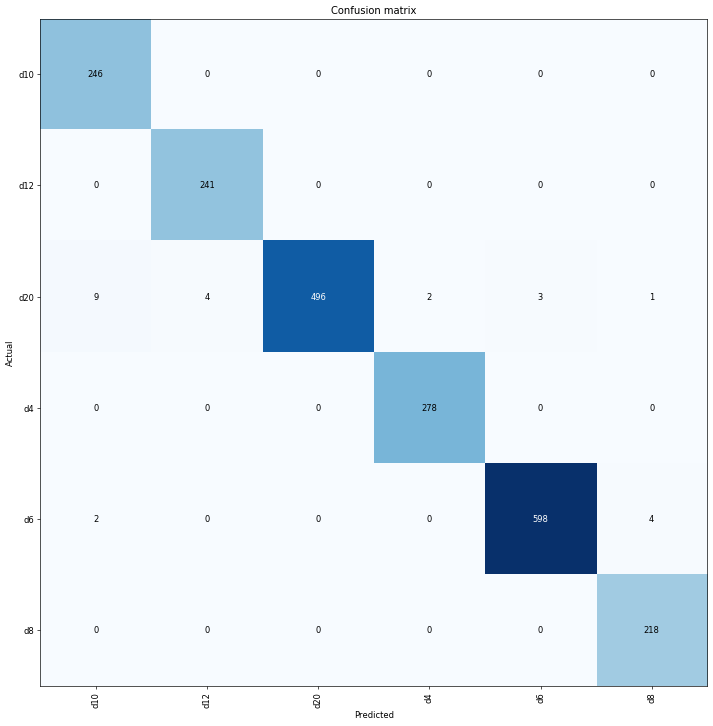

In [40]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [41]:
print('Actual, Predicted, Count')
interp.most_confused(min_val=2)

Actual, Predicted, Count


[('d20', 'd10', 9),
 ('d20', 'd12', 4),
 ('d6', 'd8', 4),
 ('d20', 'd6', 3),
 ('d20', 'd4', 2),
 ('d6', 'd10', 2)]

## Unfreezing, fine-tuning, and learning rates

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


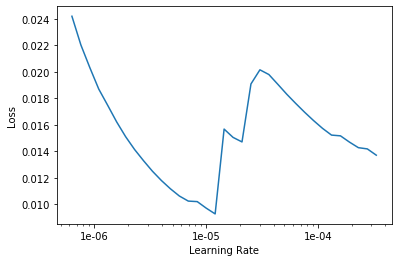

In [43]:
# Update more than just the final few layers.
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [44]:
# Change the learning rate
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.010175,0.086034,0.987155,01:49
1,0.003834,0.076432,0.988107,01:49
2,0.003386,0.076884,0.988107,01:49


[('d20', 'd10', 9),
 ('d20', 'd12', 4),
 ('d20', 'd6', 3),
 ('d6', 'd8', 3),
 ('d20', 'd4', 2),
 ('d6', 'd10', 2)]

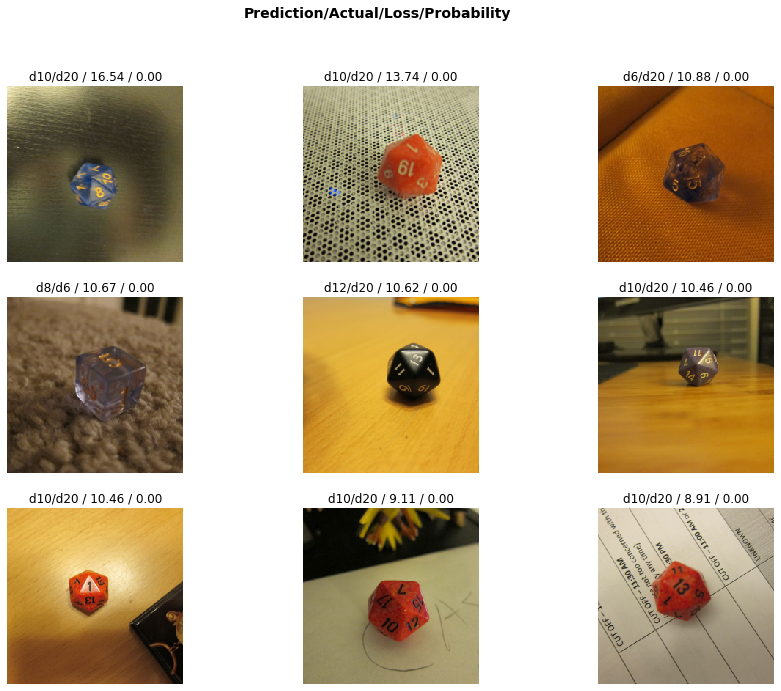

In [45]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))
interp.most_confused(min_val=2)

## Training: resnet34

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


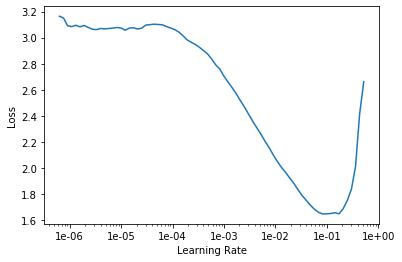

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.lr_find()
learn.recorder.plot()

In [13]:
torch.cuda.empty_cache()
learn.fit_one_cycle(4, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.240248,0.195347,0.065200,02:53
1,0.143735,0.151832,0.045600,02:48
2,0.085633,0.078167,0.027200,02:49
3,0.053548,0.065404,0.022400,02:44


In [14]:
learn.save('res-34')

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('d10', 'd8', 12),
 ('d20', 'd10', 6),
 ('d10', 'd12', 5),
 ('d20', 'd12', 5),
 ('d6', 'd12', 4),
 ('d12', 'd6', 3),
 ('d10', 'd20', 2),
 ('d10', 'd6', 2),
 ('d12', 'd20', 2),
 ('d20', 'd8', 2),
 ('d6', 'd10', 2),
 ('d6', 'd20', 2),
 ('d8', 'd4', 2)]

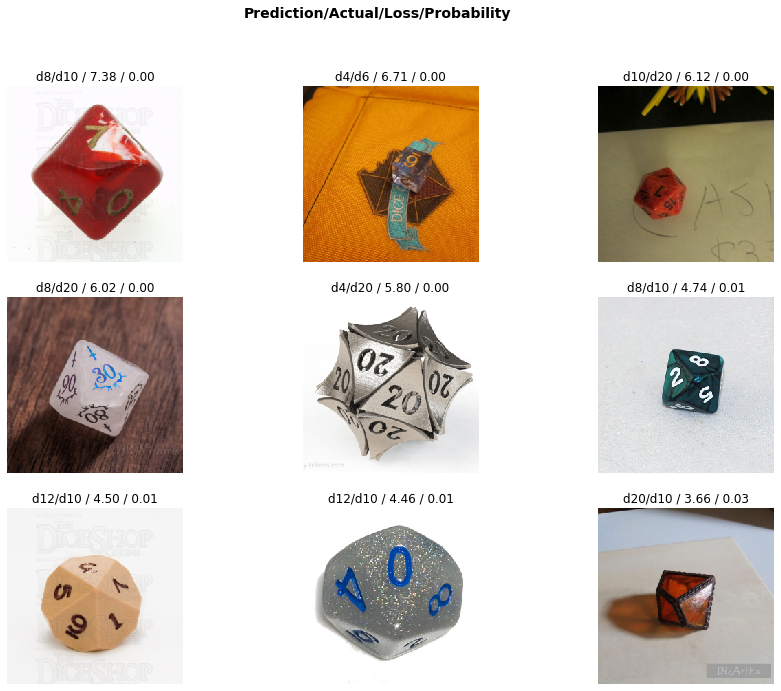

In [16]:
interp.plot_top_losses(9, figsize=(15,11))

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


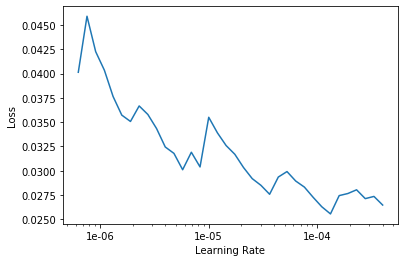

In [23]:
# Update more than just the final few layers.
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(1, max_lr=slice(2e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.037777,0.051056,0.017200,03:23


In [13]:
learn.load('res-34-unfroze')

Learner(data=ImageDataBunch;

Train: LabelList (15933 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
d10,d10,d10,d10,d10
Path: /home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice;

Valid: LabelList (2500 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
d10,d10,d10,d10,d10
Path: /home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), s

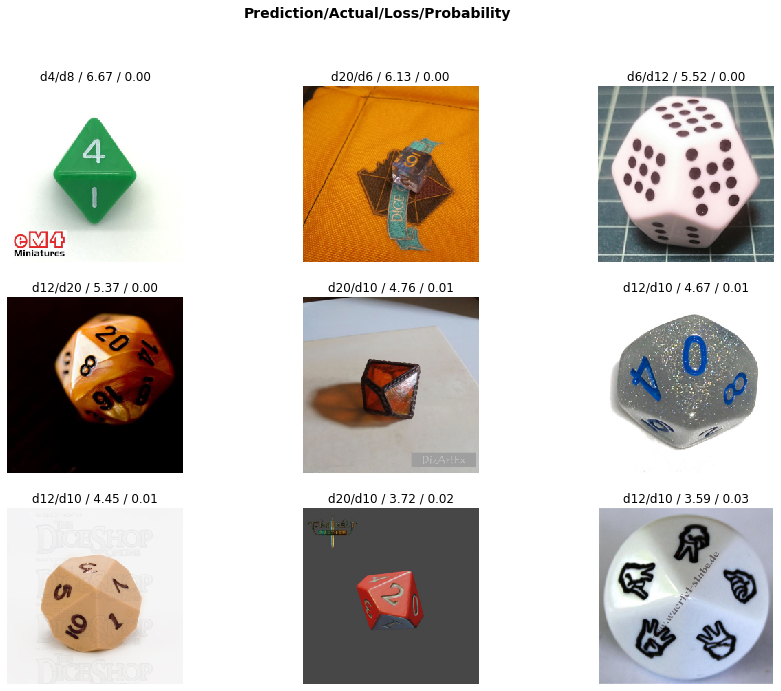

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)
interp.plot_top_losses(9, figsize=(15,11))

In [25]:
learn.save('res-34-unfroze')

In [19]:
learn.save('res-34-unfroze')
learn.load('res-34')

Learner(data=ImageDataBunch;

Train: LabelList (15933 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
d10,d10,d10,d10,d10
Path: /home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice;

Valid: LabelList (2500 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
d10,d10,d10,d10,d10
Path: /home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), s

In [31]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


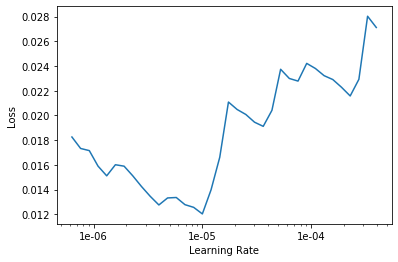

In [32]:
learn.recorder.plot()

In [59]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.004288,0.047041,0.009990,02:49
1,0.002452,0.049642,0.010466,02:49


[('d20', 'd10', 8),
 ('d20', 'd8', 4),
 ('d20', 'd12', 3),
 ('d20', 'd4', 3),
 ('d6', 'd12', 2)]

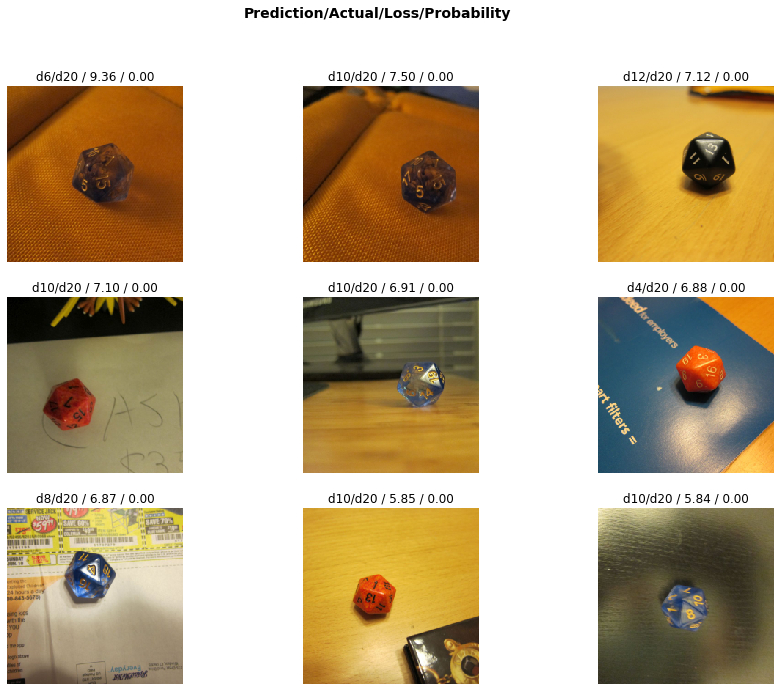

In [60]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))
interp.most_confused(min_val=2)

In [64]:
print(data.classes)
print(data.c)

['d10', 'd12', 'd20', 'd4', 'd6', 'd8']
6


# Test image

In [72]:
help(learn.export())

Help on NoneType object:

class NoneType(object)
 |  Methods defined here:
 |  
 |  __bool__(self, /)
 |      self != 0
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.



In [91]:
??learn.predict

In [28]:
help(learn.export)

Help on method export in module fastai.basic_train:

export(file: Union[pathlib.Path, str, _io.BufferedWriter, _io.BytesIO] = 'export.pkl', destroy=False) method of fastai.basic_train.Learner instance
    Export the state of the `Learner` in `self.path/file`. `file` can be file-like (file or buffer)



In [15]:
learn.export()
#learn.export(file='resnet34.pkl')

In [73]:
print(learn)

Learner(data=ImageDataBunch;

Train: LabelList (14284 items)
x: ImageList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: CategoryList
d10,d10,d10,d10,d10
Path: /home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice;

Valid: LabelList (2102 items)
x: ImageList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: CategoryList
d10,d10,d10,d10,d10
Path: /home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), s

In [76]:
# Set the device to use the cpu when just testing an image
defaults.device = torch.device('cpu')

In [80]:
path

PosixPath('/home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice')

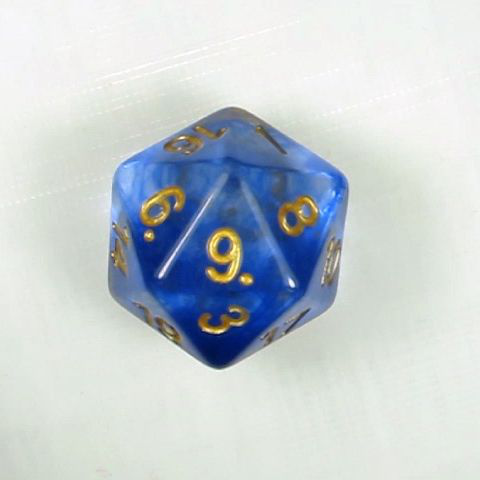

In [97]:
img = open_image(path/'valid'/'d20'/'d20_top_000.jpg')
img

In [98]:
learn = load_learner(path)

In [104]:
doc(load_learner)

In [105]:
path

PosixPath('/home/groot/.fastai/data/../../code/datasets/dice/dice-d4-d6-d8-d10-d12-d20/dice')

In [85]:
??learn.predict

In [103]:
pred_class, pred_idx, outputs = learn.predict(img)
print(pred_class)
print(pred_idx)
print(outputs)

d20
tensor(2)
tensor([1.8988e-08, 1.1940e-09, 1.0000e+00, 1.2244e-10, 1.2316e-11, 4.4378e-11])


In [1]:
data.classes

NameError: name 'data' is not defined